***Developing a predictive model to forecast monthly product sales for various stores***

The Kaggle competition <a href="https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data">"Predict Future Sales"</a> involves forecasting the total amount of products sold for every product and store in the next month, given a time-series dataset of daily historical sales. The dataset includes information on shops, products, daily sales, prices, and categories, with shop and product lists. 

The goal is to build a robust predictive model to estimate sales quantities for the test set to forecast future demand.

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [235]:
sales = pd.read_csv('data/sales_train.csv')
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

print(sales.info())
print(sales.describe())
print(sales.isnull().sum())
print(sales.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.56

In [237]:
print(items.info())
print(items.describe())
print(items.isnull().sum())
print(items.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None
           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    11084.50000         40.000000
75%    16626.75000         58.000000
max    22169.00000         83.000000
item_name           0
item_id             0
item_category_id    0
dtype: int64
                                             item_name  item_id  \
5516   PLANT ROBERT  Lullaby And... The Ceaseless Roar     5516   
15244      Мягкая игрушка Angry Birds  12,5 см  свинка    1

In [239]:
print(item_categories.info())
print(item_categories.describe())
print(item_categories.isnull().sum())
print(item_categories.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
item_category_name    0
item_category_id      0
dtype: int64
                        item_category_name  item_category_id
72                       Подарки - Фигурки                72
25               Игры - Аксессуары для игр                25
83                        Элементы питания                83
65  Подарки - Настольные игры (компактные)                65
59              Музыка - Музыкальное видео                59


In [241]:
print(shops.info())
print(shops.describe())
print(shops.isnull().sum())
print(shops.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000
shop_name    0
shop_id      0
dtype: int64
                         shop_name  shop_id
47          Сургут ТРЦ "Сити Молл"       47
33               Мытищи ТРК "XL-3"       33
27  Москва ТЦ "МЕГА Белая Дача II"       27
22              Москва Магазин С21       22
21          Москва МТРЦ "Афи Молл"       21


In [243]:
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year

sales = pd.merge(sales, items, on='item_id', how='left')

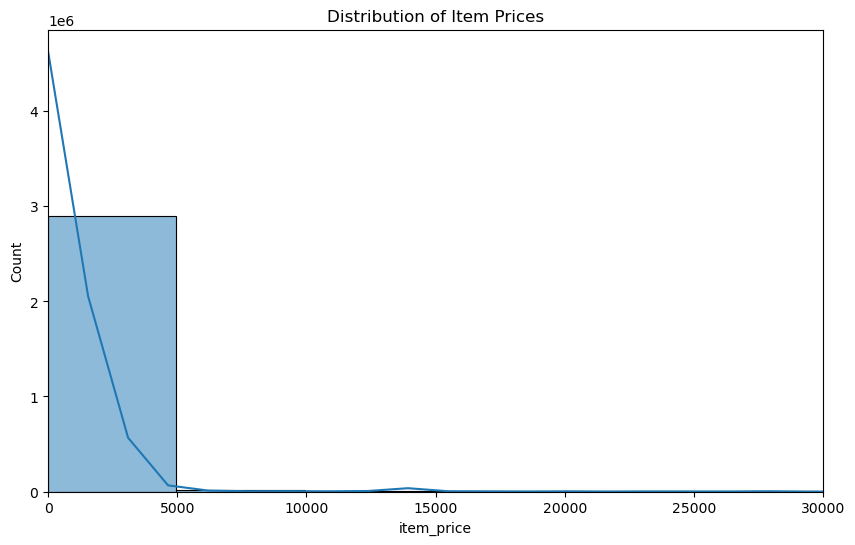

In [245]:
plt.figure(figsize=(10, 6))
sns.histplot(data=sales, x="item_price", kde=True, binwidth=5000)  
plt.xlim(0, 30000)  
plt.title("Distribution of Item Prices")
plt.show()

### Observations on Distribution of Item Prices

**Highly Skewed Distribution:** The distribution of item prices is highly right-skewed, with the majority of items priced at the lower end of the range.

**Concentration of Prices:** Most of the item prices fall between 0 and 5000, with a sharp decline in count as prices increase.

**Sparse High-Price Items:** Very few items are priced beyond 5000, and the counts drastically drop off as prices approach 30000.

**Possible Outliers:** There appear to be some extremely high-priced items (up to 30,000), which may act as outliers in the dataset.

**Need for Transformation:** Due to the heavy skewness, applying a log transformation or normalization may help in analyzing and modeling this data.

**Insight:** Since most transactions/items are concentrated in the low-price segment, business strategies can be optimized for this range.


In [249]:
sales["item_cnt_day"].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

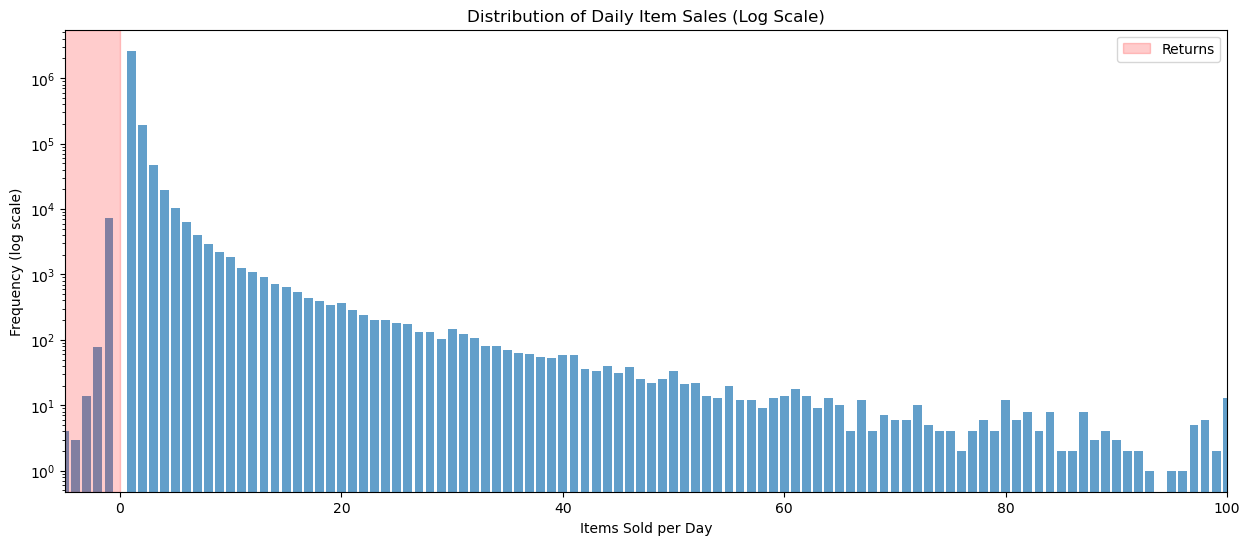

In [251]:
#Number of items sold daily
counts = sales["item_cnt_day"].value_counts().sort_index()

plt.figure(figsize=(15,6))
plt.bar(counts.index, counts.values, width=0.8, alpha=0.7)

plt.yscale('log')  # log scale for frequency
plt.xlim(-5, 100)
plt.xlabel("Items Sold per Day")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Daily Item Sales (Log Scale)")

# Highlight returns if present
if (sales["item_cnt_day"] < 0).any():
    plt.axvspan(sales["item_cnt_day"].min(), 0, color='red', alpha=0.2, label='Returns')
    plt.legend()

plt.show()

In [253]:
monthly_trend = sales.groupby(['year', 'month'])['item_cnt_day'].sum().reset_index()

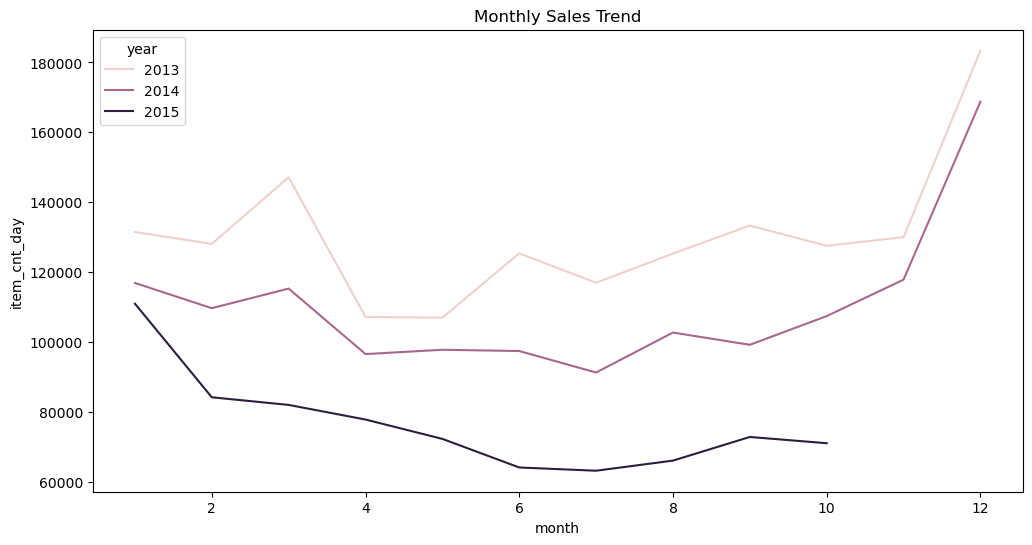

In [255]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trend, x='month', y='item_cnt_day', hue='year')
plt.title('Monthly Sales Trend')
plt.show()

In [257]:
sales[sales['item_cnt_day']>30].shape

(1614, 10)

In [259]:
# Most of the item prices fall between 0 and 30000. 
sales = sales[sales['item_price'] < 30000]
sales = sales[sales['item_id'] > 0]

In [261]:
sales = sales.drop_duplicates()
sales.shape

(2935602, 10)

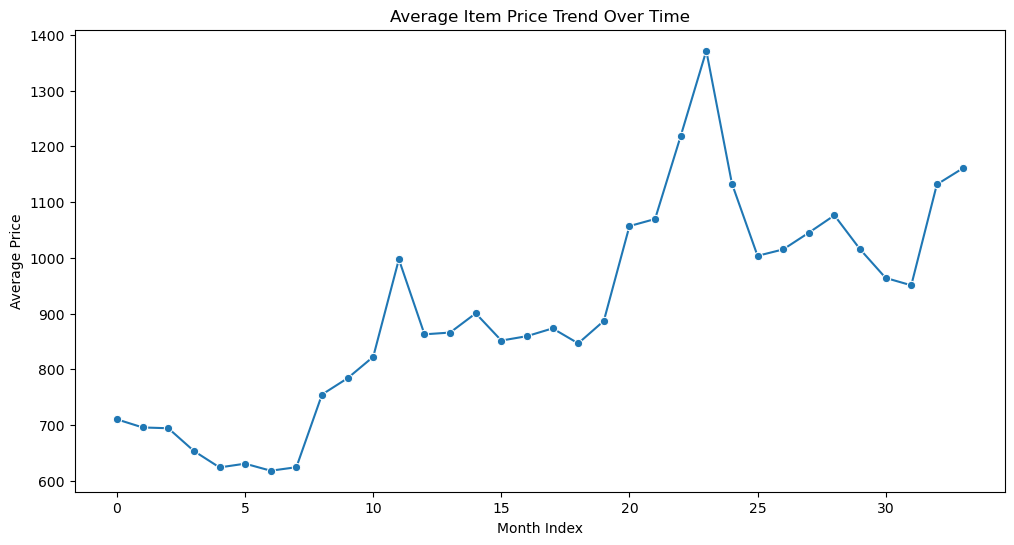

In [262]:

price_trend = sales.groupby('date_block_num')['item_price'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=price_trend, x='date_block_num', y='item_price', marker='o')
plt.title('Average Item Price Trend Over Time')
plt.xlabel('Month Index')
plt.ylabel('Average Price')
plt.show()


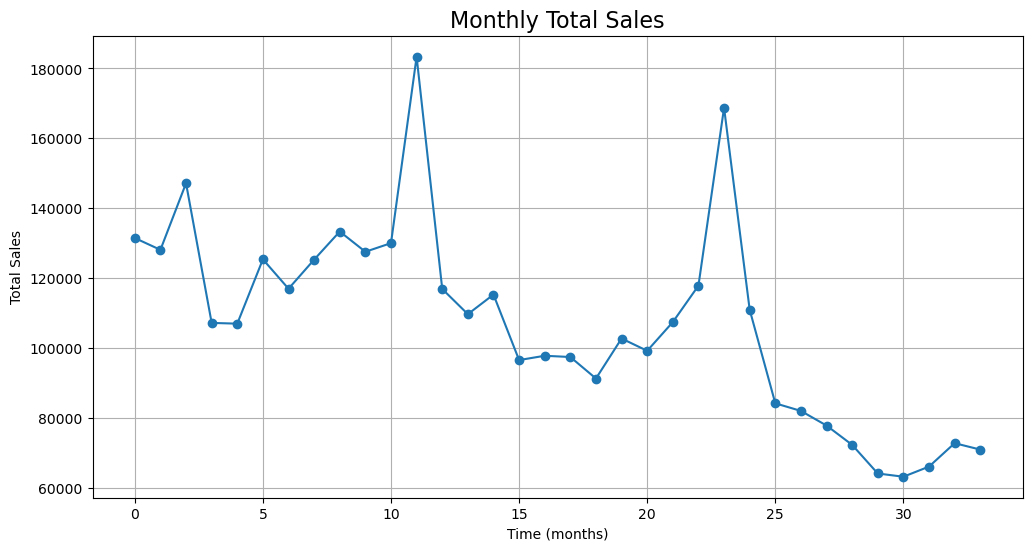

In [263]:
monthly_total = sales.groupby('date_block_num')['item_cnt_day'].sum()

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_total.index, monthly_total.values, marker='o', linestyle='-')
plt.title('Monthly Total Sales', fontsize=16)
plt.xlabel('Time (months)')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

### Observations: Average Item Price Trend Over Time

**Upward trend:** The average item price has increased significantly over time.

**Notable spikes:** Sharp price peaks are observed around months 11 and 23, possibly due to the introduction of new high-priced items or seasonal (Xmas) pricing adjustments.

**Volatility:** While the overall trend is upward, there are short-term fluctuations, suggesting periodic promotions, new product launches, or pricing corrections.

**Trend:** There is a gradual decline in overall sales after the initial months, indicating a long-term downward movement in the dataset.
Price action: Strong sales recurring peaks appear around the end of each year (e.g., month 11 and 23), representing holiday season spikes.


**Insight:** 
    - Price dynamics likely influence sales volumes and should be included as a feature in predictive models.
    - Sales behavior is heavily influenced by annual seasonality (December boosts) and a downward long-term trend, which must be captured in forecasting models.

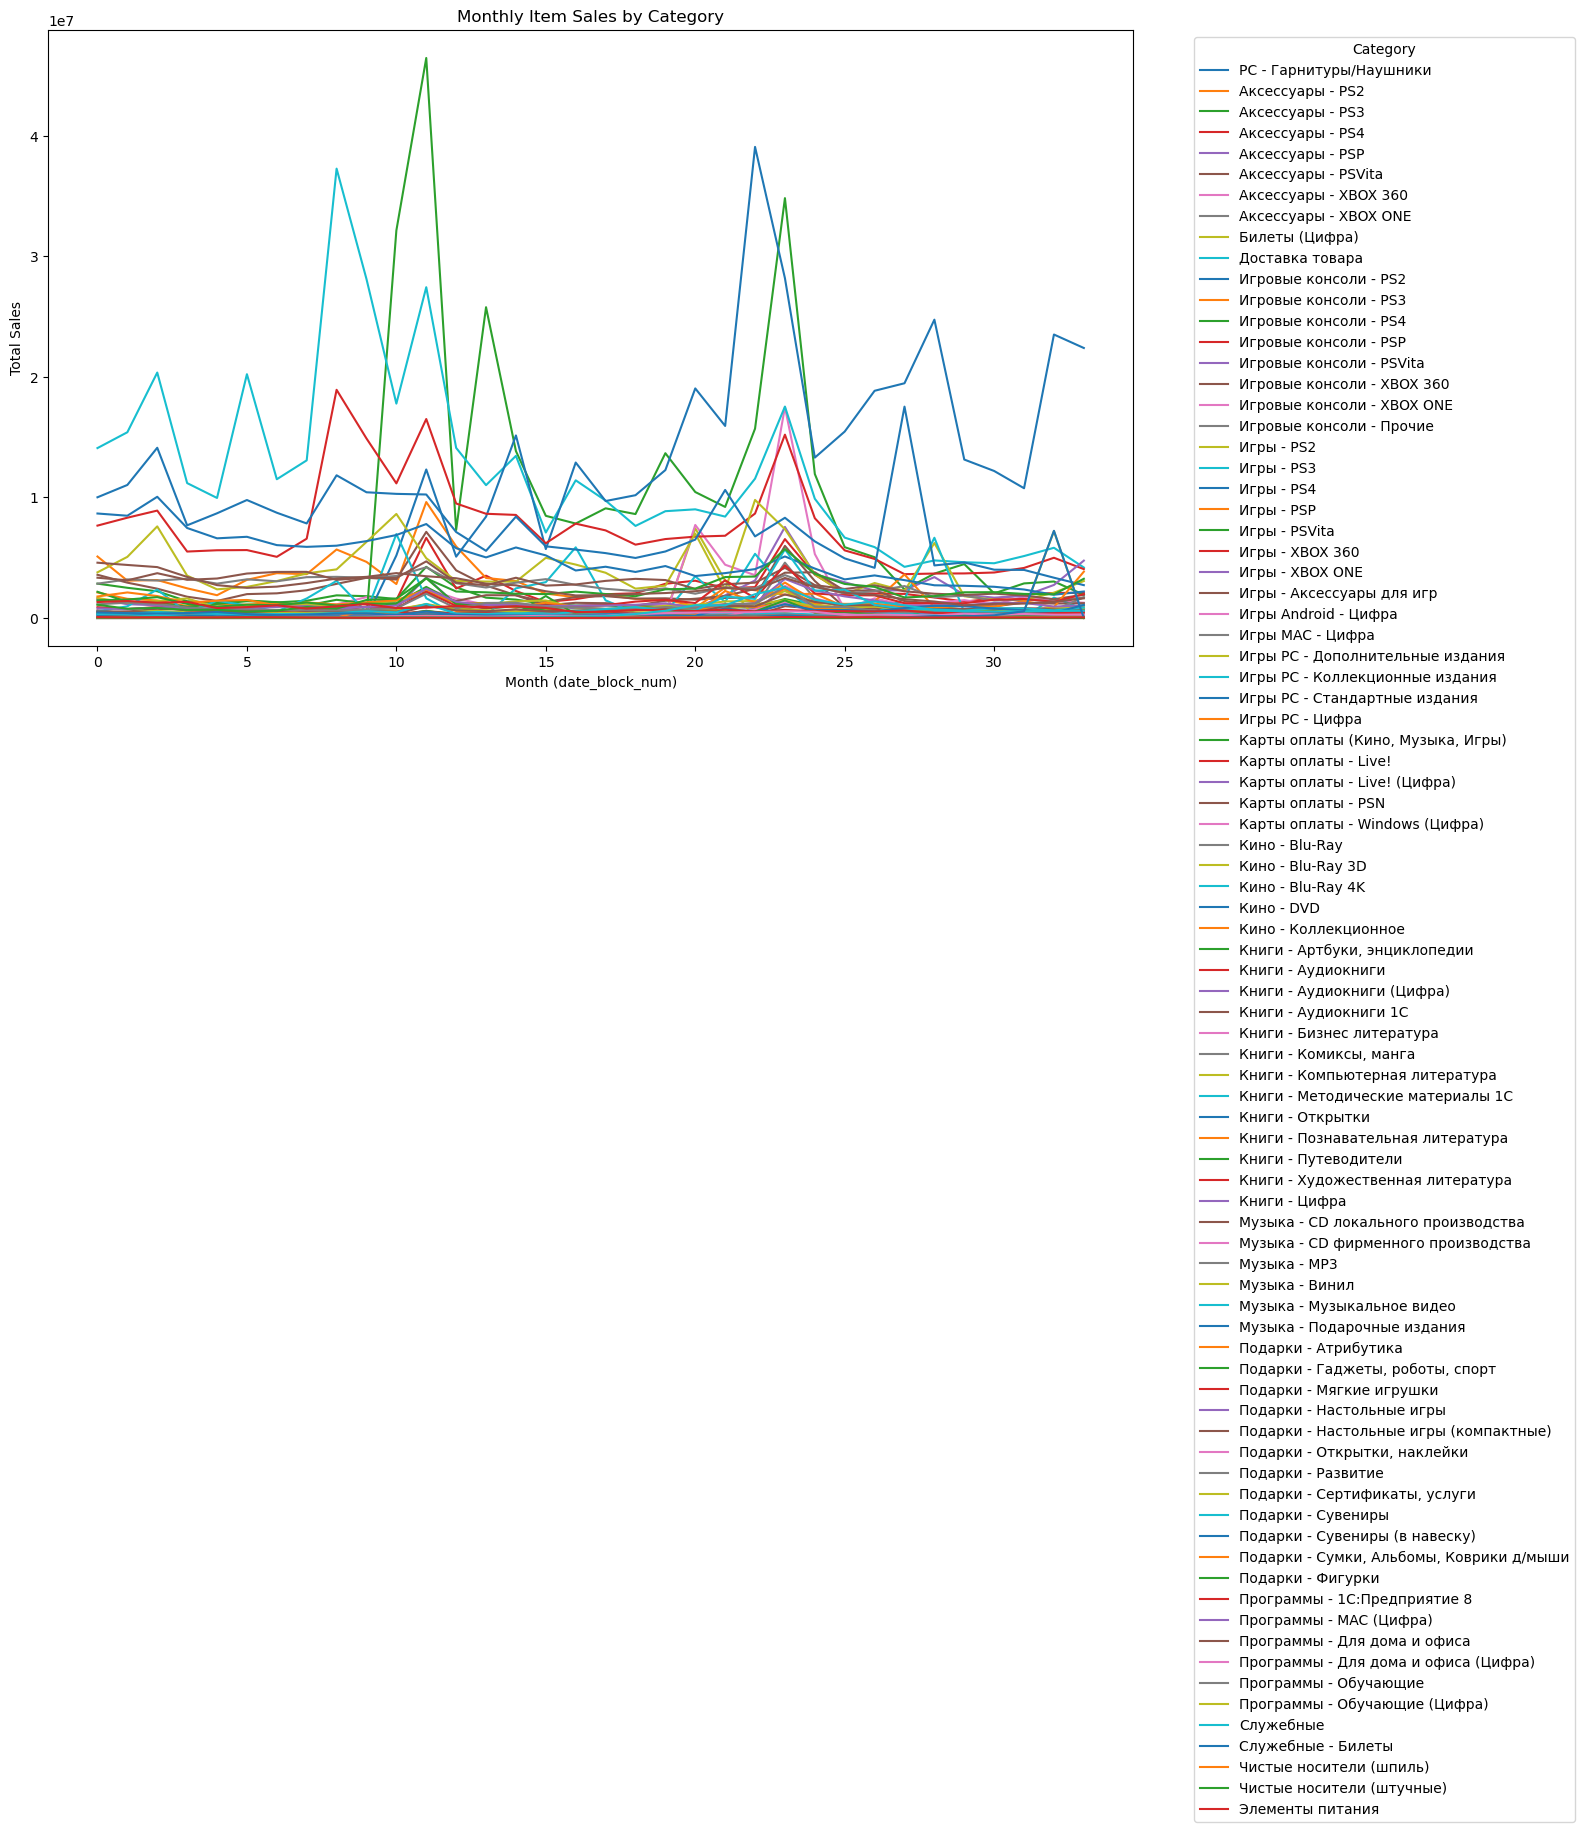

In [265]:
# Create total_sales column
sales['total_sales'] = sales['item_price'] * sales['item_cnt_day']

# Merge with categories
df_cat = sales.merge(item_categories[['item_category_id', 'item_category_name']], on='item_category_id', how='left')

# Aggregate sales by month and category
monthly_category_sales = (
    df_cat.groupby(['date_block_num', 'item_category_name'])['total_sales']
          .sum()
          .unstack(fill_value=0)
)

# Plot sales by category
monthly_category_sales.plot(kind='line', figsize=(14, 8))
plt.title('Monthly Item Sales by Category')
plt.xlabel('Month (date_block_num)')
plt.ylabel('Total Sales')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


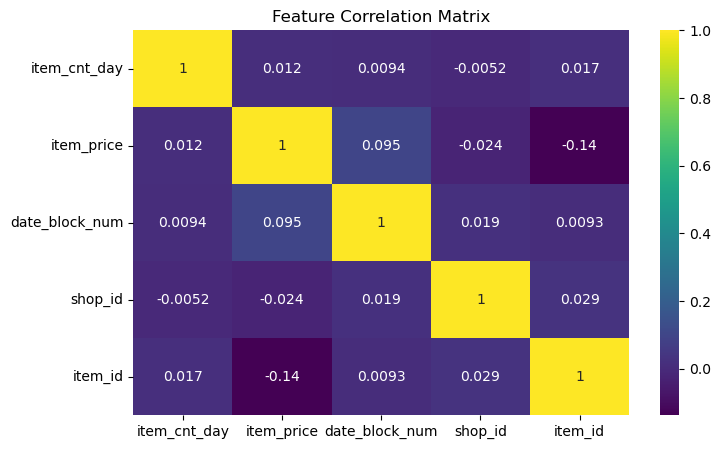

In [266]:
features = ['item_cnt_day', 'item_price', 'date_block_num', 'shop_id', 'item_id']
corr_matrix = sales[features].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Feature Correlation Matrix')
plt.show()

In [267]:
top_items = sales.groupby('item_id')['item_cnt_day'].sum().sort_values(ascending=False)[0:10]
print(top_items)


item_id
20949    187642.0
2808      17245.0
3732      16642.0
17717     15830.0
5822      14515.0
3734      11688.0
6675      10289.0
3731      10099.0
1855      10032.0
16787      9227.0
Name: item_cnt_day, dtype: float64


In [268]:
top_shops = sales.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False)[0:10]
print(top_shops)

shop_id
31    310761.0
25    241903.0
54    185783.0
28    184548.0
42    144916.0
57    141099.0
27    136653.0
6     100482.0
58     81730.0
46     78983.0
Name: item_cnt_day, dtype: float64


<Axes: xlabel='item_price'>

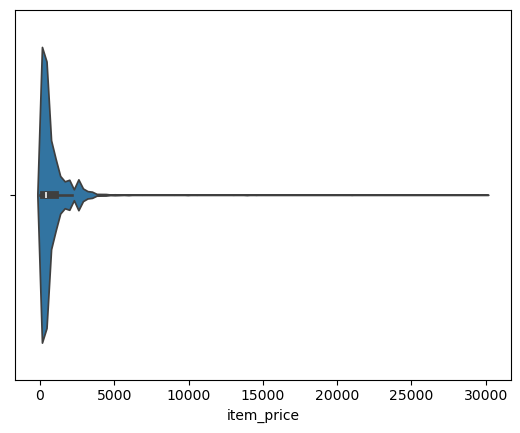

In [269]:
sns.violinplot(x=sales['item_price'], orient='h')

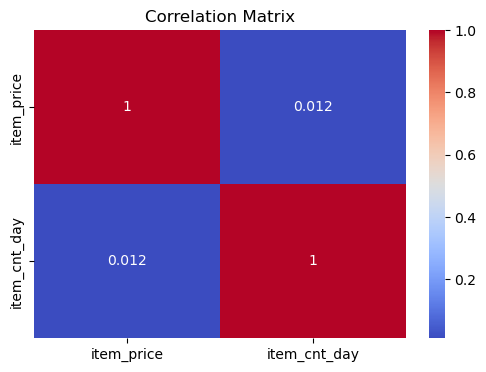

In [270]:
corr_matrix = sales[['item_price', 'item_cnt_day']].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [271]:
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

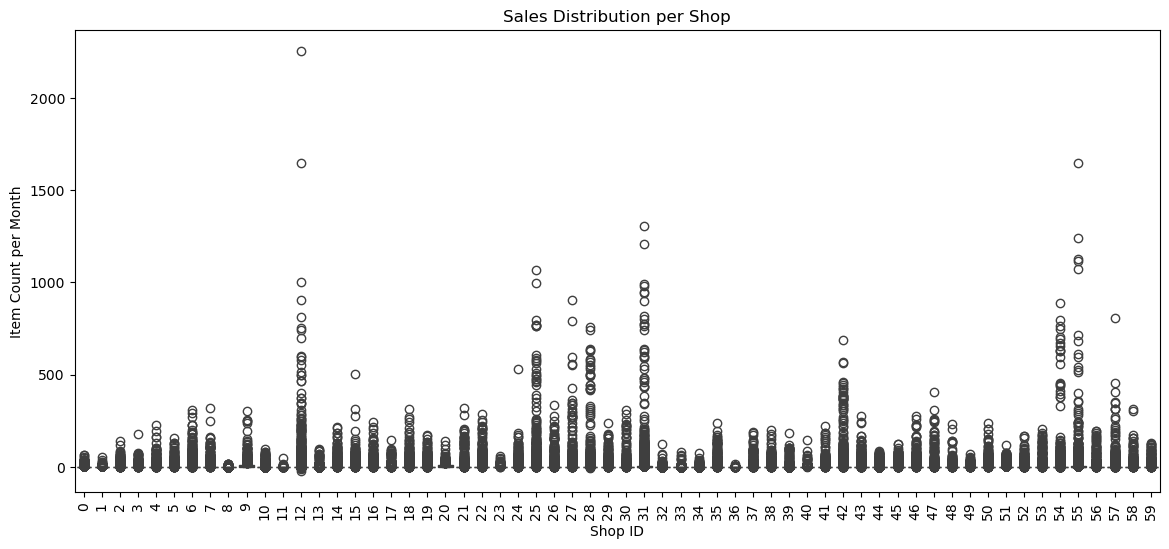

In [272]:
plt.figure(figsize=(14,6))
sns.boxplot(x='shop_id', y='item_cnt_month', data=monthly_sales)
plt.title('Sales Distribution per Shop')
plt.xlabel('Shop ID')
plt.ylabel('Item Count per Month')
plt.xticks(rotation=90)
plt.show()

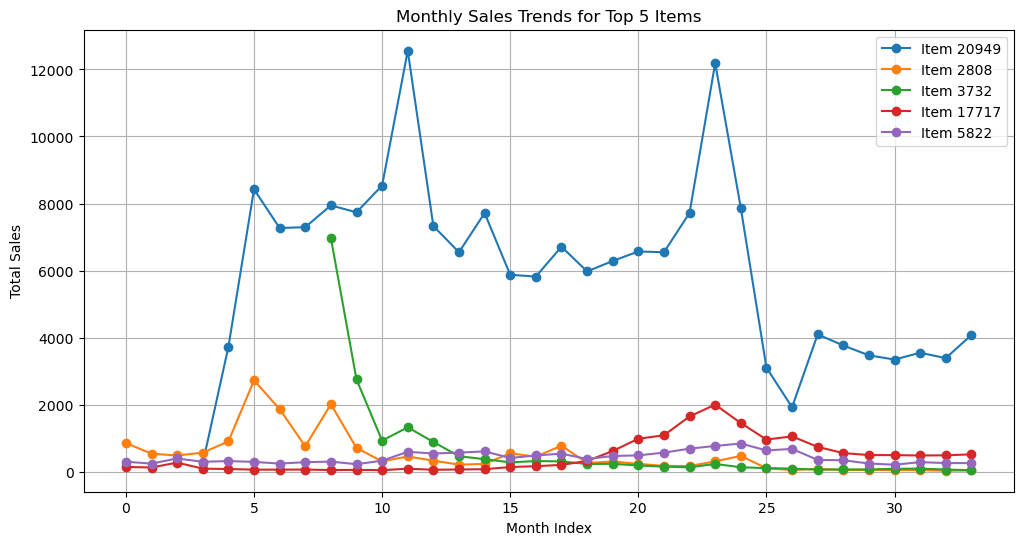

In [273]:
top_5_items = monthly_sales.groupby('item_id')['item_cnt_month'].sum().nlargest(5).index

plt.figure(figsize=(12,6))
for item in top_5_items:
    item_data = monthly_sales[monthly_sales['item_id'] == item]
    monthly_totals = item_data.groupby('date_block_num')['item_cnt_month'].sum()
    plt.plot(monthly_totals.index, monthly_totals.values, marker='o', label=f'Item {item}')
    
plt.title("Monthly Sales Trends for Top 5 Items")
plt.xlabel("Month Index")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.show()


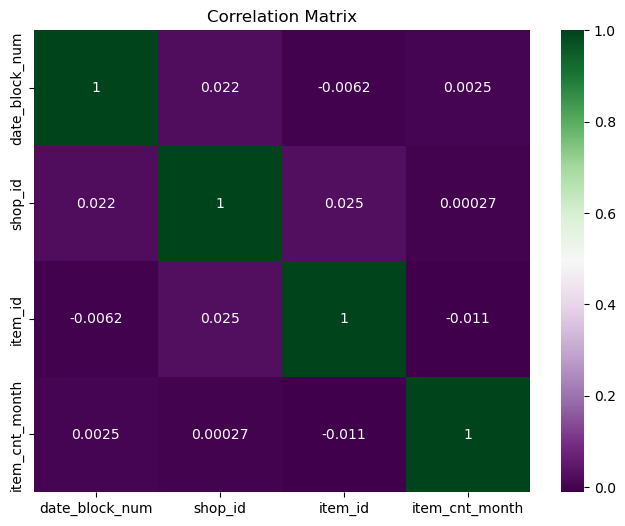

In [274]:
corr = monthly_sales.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="PRGn")
plt.title('Correlation Matrix')
plt.show()

### Observations: Correlation Matrix

**Weak correlations between features:**
   - 'shop_id', 'item_id', and 'date_block_num' have **very low correlation** with 'item_cnt_month' (sales), indicating that these individual features do not strongly explain sales on their own.

**Key Takeaway:**  
The raw features (shop, item, month index) by themselves are **not sufficient to explain sales variance**, highlighting the importance of creating **derived features** (e.g., rolling averages, seasonal patterns, price effects) for better forecasting models.

In [276]:
#complete grid of all possible (shop, item, month) combinations
grid = []
for block_num in range(34):
    cur_shops = sales[sales['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num'] == block_num]['item_id'].unique()
    grid.append(np.array(list(itertools.product(cur_shops, cur_items, [block_num]))))

# Combine all monthly grids into one DataFrame
grid = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'])

monthly_sales = pd.merge(grid, monthly_sales, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

for lag in [1, 2, 3]:
    monthly_sales[f'item_cnt_month_lag_{lag}'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)

In [277]:
item_id_target_mean = monthly_sales.groupby(['item_id'])['item_cnt_month'].mean().reset_index()
item_id_target_mean.columns = ['item_id', 'item_target_enc']
monthly_sales = pd.merge(monthly_sales, item_id_target_mean, on=['item_id'], how='left')

shop_id_target_mean = monthly_sales.groupby(['shop_id'])['item_cnt_month'].mean().reset_index()
shop_id_target_mean.columns = ['shop_id', 'shop_target_enc']
monthly_sales = pd.merge(monthly_sales, shop_id_target_mean, on=['shop_id'], how='left')

monthly_sales = pd.merge(monthly_sales, items[['item_id', 'item_category_id']], on='item_id', how='left')

monthly_sales['month'] = monthly_sales['date_block_num'] % 12 + 1

In [278]:
monthly_sales.dropna(inplace=True)

In [279]:

le_shop = LabelEncoder()
monthly_sales['shop_id'] = le_shop.fit_transform(monthly_sales['shop_id'])

le_item = LabelEncoder()
monthly_sales['item_id'] = le_item.fit_transform(monthly_sales['item_id'])

le_category = LabelEncoder()
monthly_sales['item_category_id'] = le_category.fit_transform(monthly_sales['item_category_id'])

In [280]:
monthly_sales[monthly_sales["item_id"]>5000].shape

(5522371, 11)

In [281]:
X_train = monthly_sales[monthly_sales['date_block_num'] < 33]
X_test = monthly_sales[monthly_sales['date_block_num'] == 33]

y_train = X_train['item_cnt_month']
y_test = X_test['item_cnt_month']

X_train = X_train.drop(['item_cnt_month'], axis=1)
X_test = X_test.drop(['item_cnt_month'], axis=1)

In [282]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [283]:
df = monthly_sales.sample(frac=0.05, random_state=42) if len(monthly_sales) > 1e6 else monthly_sales
df.shape

(398558, 11)

# Training Models: #




In [319]:

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=['Model', 'RMSE', 'Training Time (s)'])
target = monthly_sales['item_cnt_month'].values

### Linear Regression: ###

In [322]:
start_time = time.time()

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
rmse_lr = sqrt(mean_squared_error(y_test, predictions_lr))

training_time = time.time() - start_time
results.loc[len(results)] = ['Linear Regression', rmse_lr, training_time]
print("RMSE for  Linear Regression Model:", rmse_lr)
print("Time for  Linear Regression Model:", training_time)

RMSE for  Linear Regression Model: 5.29720245288519
Time for  Linear Regression Model: 1.5426504611968994


In [323]:
rmse_lr_train = sqrt(mean_squared_error(y_train, model_lr.predict(X_train)))
rmse_lr_train

1.9881256916571841

### Ridge Regression (L2 Regularization): ###

In [327]:
# Ridge Regression (L2 Regularization)
start_time = time.time()
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)
ridge_rmse = sqrt(mean_squared_error(y_test, ridge_preds))
results.loc[len(results)] = ['Ridge Regression', ridge_rmse, time.time() - start_time]

print("RMSE for Ridge Regression Model:", ridge_rmse)
print("Time for Ridge Regression Model:", time.time() - start_time)

RMSE for Ridge Regression Model: 5.297202507529603
Time for Ridge Regression Model: 0.6394801139831543


In [329]:
rmse_Ridge_train = sqrt(mean_squared_error(y_train, ridge.predict(X_train)))
rmse_Ridge_train

1.9881256916572148

### ARIMA: ###

In [332]:
start_time = time.time()

model_arima = ARIMA(target, order=(2, 1, 1))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.predict(start=3, end=len(target)-1)
rmse_arima = sqrt(mean_squared_error(target[3:], predictions_arima))

training_time = time.time() - start_time
results.loc[len(results)] = ['ARIMA(2,1,1)', rmse_arima, training_time]
print("RMSE for ARIMA Model:", rmse_arima)
print("Time for ARIMA Model:", training_time)

RMSE for ARIMA Model: 3.36815021268885
Time for ARIMA Model: 1077.5609035491943


### Decision Tree Regressor:  ###

In [335]:
start_time = time.time()

# Decision Tree Model
model_dt = DecisionTreeRegressor(
            max_depth=5,           
            min_samples_split=20,  
            min_samples_leaf=10,   
            random_state=42
        )
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)
rmse_dt = sqrt(mean_squared_error(y_test, predictions_dt))

training_time = time.time() - start_time
results.loc[len(results)] = ['Decision Tree', rmse_dt, training_time]
print("RMSE for Decision Tree Model:", rmse_dt)
print("Time for Decision Tree Model:", training_time)

RMSE for Decision Tree Model: 5.429583834965124
Time for Decision Tree Model: 14.826789140701294


In [336]:
rmse_dt_train = sqrt(mean_squared_error(y_train, model_dt.predict(X_train)))
rmse_dt_train

1.8346218001557497

### Random Forest Regressor:  ###

In [340]:
start_time = time.time()

# Random Forest Model
model_rf = RandomForestRegressor(
                n_estimators=100,        
                max_depth=10,            
                min_samples_split=5,    
                min_samples_leaf=2,      
                max_features='sqrt',     
                random_state=42,         
                n_jobs=-1,               
                verbose=0    )
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
rmse_rf = sqrt(mean_squared_error(y_test, predictions_rf))

training_time = time.time() - start_time
results.loc[len(results)] = ['Random Forest', rmse_rf, training_time]
print("RMSE for Random Forest Model:", rmse_rf)
print("Time for Random Forest Model:", training_time)

RMSE for Random Forest Model: 5.194260350821161
Time for Random Forest Model: 220.67761063575745


In [341]:
rmse_rf_train = sqrt(mean_squared_error(y_train, model_rf.predict(X_train)))
rmse_rf_train

1.335616701959647

### KNN Regressor: ###

In [347]:
start_time = time.time()


knn = KNeighborsRegressor(
    n_neighbors=15,        
    weights='uniform',    
    algorithm='auto',
    n_jobs=-1
)

knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_rmse = sqrt(mean_squared_error(y_test, knn_preds))
knn_time = time.time() - start_time
results.loc[len(results)] = ['KNN', knn_rmse, knn_time]

print("RMSE for KNN Model:", knn_rmse)
print("Time for KNN Model:", knn_time)

RMSE for KNN Model: 5.187847246924082
Time for KNN Model: 245.47308206558228


In [ ]:
rmse_knn_train = sqrt(mean_squared_error(y_train, knn.predict(X_train)))
rmse_knn_train

In [349]:
!pip install xgboost
from xgboost import XGBRegressor

In [351]:
start_time = time.time()

model_xgb = XGBRegressor(
    n_estimators=500,       # number of boosting rounds (trees)
    learning_rate=0.05,     # shrinkage step
    max_depth=5,            # depth of trees
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    min_child_weight=5,     # minimum sum of weights in a child
    random_state=42,
    n_jobs=-1               # use all CPU cores
)


model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)
training_time = time.time() - start_time
results.loc[len(results)] = ['XGBoost', rmse_xgb, training_time]
print("RMSE for XGBoost Model:", rmse_xgb)
print("Time for XGBoost Model:", training_time)

RMSE for XGBoost Model: 8.08806139617948
Time for XGBoost Model: 124.66468048095703


In [352]:
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
rmse_xgb

8.08806139617948

In [353]:
# =================== m=====================================================
# Display Results
# ========================================================================
print("\nModel Performance Comparison:")
print(results.to_markdown(index=False, floatfmt=".3f"))


Model Performance Comparison:
| Model             |   RMSE |   Training Time (s) |
|:------------------|-------:|--------------------:|
| Linear Regression |  5.297 |               1.543 |
| Ridge Regression  |  5.297 |               0.639 |
| ARIMA(2,1,1)      |  3.368 |            1077.561 |
| Decision Tree     |  5.430 |              14.827 |
| Random Forest     |  5.194 |             220.678 |
| KNN               |  5.188 |             262.813 |
| KNN               |  5.188 |             245.473 |
| XGBoost           |  8.088 |             124.665 |
